# Proyek Klasifikasi Gambar: Intel Image Classification
- **Nama:** Stefanus Betanius Prakoso
- **Email:** mc180d5y0530@student.devacademy.id
- **ID Dicoding:** MC180D5Y0530

## Import Semua Packages/Library yang Digunakan

In [16]:
import os
import shutil
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

## Data Preparation

### Data Loading

In [4]:
from google.colab import files
uploaded = files.upload()

Saving seg.zip to seg.zip


In [5]:
import zipfile

with zipfile.ZipFile("seg.zip", 'r') as zip_ref:
    zip_ref.extractall()

In [7]:
def prepare_data(original_data_dir, base_output_dir, split_ratio=(0.7, 0.15, 0.15), seed=42):
    random.seed(seed)
    classes = os.listdir(original_data_dir)

    for cls in classes:
        cls_path = os.path.join(original_data_dir, cls)
        if not os.path.isdir(cls_path):
            continue
        images = os.listdir(cls_path)
        random.shuffle(images)

        train_size = int(len(images) * split_ratio[0])
        val_size = int(len(images) * split_ratio[1])

        splits = {
            'train': images[:train_size],
            'val': images[train_size:train_size + val_size],
            'test': images[train_size + val_size:]
        }

        for split, split_images in splits.items():
            split_dir = os.path.join(base_output_dir, split, cls)
            os.makedirs(split_dir, exist_ok=True)
            for img in tqdm(split_images, desc=f"{cls} → {split}"):
                src = os.path.join(cls_path, img)
                dst = os.path.join(split_dir, img)
                shutil.copyfile(src, dst)

### Data Preprocessing

#### Split Dataset

In [9]:
prepare_data('seg/train', 'dataset_split')

forest → test: 100%|██████████| 342/342 [00:00<00:00, 7178.43it/s]


In [10]:
image_size = (150, 150)
batch_size = 32
dataset_path = 'dataset_split'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True
)
test_val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_path, 'train'),
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = test_val_datagen.flow_from_directory(
    os.path.join(dataset_path, 'val'),
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_val_datagen.flow_from_directory(
    os.path.join(dataset_path, 'test'),
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 9820 images belonging to 6 classes.
Found 2102 images belonging to 6 classes.
Found 2112 images belonging to 6 classes.


## Modelling

In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.3),  # Regularization
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     1,605,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,848,262 (7.05 MB)

 Trainable params: 1,848,262 (7.05 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[early_stop]
)

Epoch 1/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 70s 210ms/step - accuracy: 0.4319 - loss: 1.3580 - val_accuracy: 0.6356 - val_loss: 0.9246
Epoch 2/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 61s 199ms/step - accuracy: 0.5961 - loss: 1.0198 - val_accuracy: 0.6755 - val_loss: 0.8368
Epoch 3/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 61s 198ms/step - accuracy: 0.6588 - loss: 0.8886 - val_accuracy: 0.7398 - val_loss: 0.7317
Epoch 4/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 60s 196ms/step - accuracy: 0.7118 - loss: 0.7652 - val_accuracy: 0.7745 - val_loss: 0.6457
Epoch 5/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 59s 193ms/step - accuracy: 0.7263 - loss: 0.7308 - val_accuracy: 0.8030 - val_loss: 0.5505
Epoch 6/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 60s 196ms/step - accuracy: 0.7597 - loss: 0.6550 - val_accuracy: 0.8268 - val_loss: 0.5115
Epoch 7/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 60s 196ms/step - accuracy: 0.7780 - loss: 0.6203 - val_accuracy: 0.8059 - val_loss: 0.5300
Epoch 8/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 62s 201ms/step - accuracy: 0.7852 - loss: 0

## Evaluasi dan Visualisasi

In [19]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"\n✅ Test Accuracy: {test_acc * 100:.2f}%")

train_loss, train_acc = model.evaluate(train_generator)
print(f"✅ Train Accuracy: {train_acc * 100:.2f}%")


66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.8831 - loss: 0.3666

✅ Test Accuracy: 85.80%
307/307 ━━━━━━━━━━━━━━━━━━━━ 57s 185ms/step - accuracy: 0.8659 - loss: 0.3798
✅ Train Accuracy: 86.15%


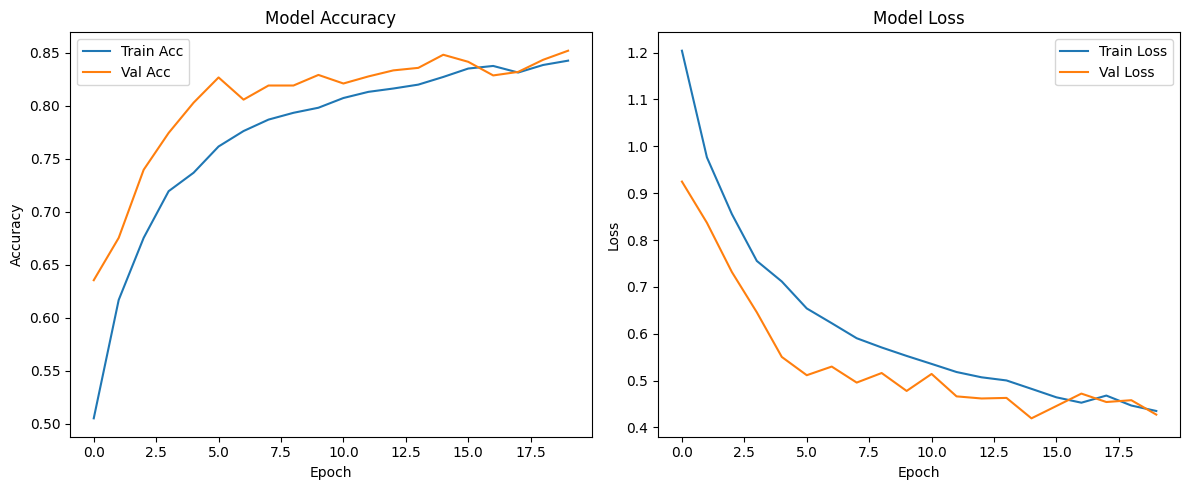

In [20]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Konversi Model

In [28]:
saved_model_dir = "saved_model"
model.export(saved_model_dir)

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_24')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  136766120758160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136766120759696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136766120759120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136766120760464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136766120759888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136766120761232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136766120760656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136766120762000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136766120761424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136766120762768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136766120762192:

In [29]:
tflite_dir = "tflite"
os.makedirs(tflite_dir, exist_ok=True)

In [30]:
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()
with open(os.path.join(tflite_dir, "model.tflite"), "wb") as f:
    f.write(tflite_model)

In [31]:
labels = list(train_generator.class_indices.keys())
with open(os.path.join(tflite_dir, "label.txt"), "w") as f:
    for label in labels:
        f.write(f"{label}\n")

In [32]:
tfjs_dir = "tfjs_model"
os.makedirs(tfjs_dir, exist_ok=True)

In [34]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [35]:
import tensorflowjs as tfjs

In [36]:
tfjs.converters.convert_tf_saved_model(saved_model_dir, tfjs_dir)

## Inference (Optional)